# Train GCN for Heat Stake Recognition

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
SEED = 60
EPOCHS = 45
LR = 0.001
DROPOUT = 0.3
VAL_SPLIT = 0.2

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.get_arch_list())
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


[]
False
Using device: cpu


# Create Dataset

In [3]:
import sys
import cadquery as cq
from pathlib import Path
import torch


# Resolve paths relative to this notebook's folder when possible
BASE_DIR = Path.cwd().parent
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))
    
from preprocessing.graphs import build_brep_graph, nx_to_PyG

DATA_DIR = BASE_DIR / "GCN" / "training_data"
HEATSTAKE_DIR = DATA_DIR / "heatstakes"
OTHER_DIR = DATA_DIR / "other"
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset.pt"

if False:
    dataset = []

    def iter_step_files(folder: Path):
        return [p for p in folder.rglob('*') if p.suffix.lower() in {'.stp', '.step'}]

    possible_heatstakes = iter_step_files(HEATSTAKE_DIR)
    possible_others = iter_step_files(OTHER_DIR)

    print(f"Found {len(possible_heatstakes)} heatstake STEP files and {len(possible_others)} other STEP files.")
    for heatstake_path in possible_heatstakes:
        solids = cq.importers.importStep(str(heatstake_path)).faces()
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([1], dtype=torch.long)  # class 1 = heatstake
        dataset.append(data[0])
    for other_path in possible_others:
        solids = cq.importers.importStep(str(other_path)).faces()    
        G = build_brep_graph(solids)
        data = nx_to_PyG([G])
        data[0].y = torch.tensor([0], dtype=torch.long)  # class 0 = other
        dataset.append(data[0])

    if len(dataset) == 0:
        print("No graphs were created. Ensure your folders contain .stp/.step files and your preprocessing functions are available.")
    else:
        torch.save(dataset, DATASET_FILE)
        print(f"Saved dataset with {len(dataset)} graphs to {DATASET_FILE}")


In [4]:
# Load dataset (expects a single .pt file saved as a list of PyG Data objects)
from pathlib import Path
import torch

BASE_DIR = Path.cwd().parent
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset.pt"

if DATASET_FILE.exists():
    dataset = torch.load(DATASET_FILE, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs from {DATASET_FILE}")
else:
    dataset = []
    print(f"Dataset file not found at {DATASET_FILE}. Add data or build dataset first.")

# Basic sanity check
if len(dataset) > 0:
    assert hasattr(dataset[0], 'x') and hasattr(dataset[0], 'edge_index') and hasattr(dataset[0], 'y'), \
        "Each Data must have x, edge_index, and y"

Loaded dataset with 330 graphs from c:\Users\MrEstebato\Documents\proyectos-programacion\ai\3d-part-localization\GCN\training_ready_dataset.pt


In [5]:
# Split into train/val (per-graph training, no batches)",
if len(dataset) > 0:
    labels = [int(d.y.item()) for d in dataset]
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=VAL_SPLIT, random_state=SEED, stratify=labels if len(set(labels)) > 1 else None)
    train_dataset = [dataset[i] for i in train_idx]
    val_dataset = [dataset[i] for i in val_idx]

    print(f"Train graphs: {len(train_dataset)} | Val graphs: {len(val_dataset)}")
else:
    train_dataset = []
    val_dataset = []


Train graphs: 264 | Val graphs: 66


In [6]:
from GCN import GCN3

# Create model, criterion, optimizer (per-graph training)
if len(train_dataset) > 0:
    in_channels = train_dataset[0].x.size(-1)
    # model = GCN(feature_dim_size=in_channels, num_classes=2, dropout=DROPOUT).to(DEVICE)
    model = GCN3(feature_dim_size=in_channels).to(DEVICE)
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

    #optimizer = optim.Adam(model.parameters(), lr=LR)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

    print(model)
else:
    model = None


GCN3(
  (conv1): GCNConv(10, 64)
  (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (conv2): GCNConv(64, 32)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (conv3): GCNConv(32, 32)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
# Train/eval helpers

def train_one_epoch(model, dataset, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for data in dataset:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(adj=data.edge_index, features=data.x)  # shape [1, 2]
        loss = criterion(out, data.y.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += int((preds == data.y).sum().item())
        total += data.y.size(0)

    avg_loss = total_loss / max(1, len(dataset))
    acc = correct / max(1, total)
    return avg_loss, acc


def evaluate(model, dataset, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataset:
            data = data.to(DEVICE)
            out = model(adj=data.edge_index, features=data.x)
            loss = criterion(out, data.y.long())
            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += int((preds == data.y).sum().item())
            total += data.y.size(0)
    avg_loss = total_loss / max(1, len(dataset))
    acc = correct / max(1, total)
    return avg_loss, acc

Epoch 001 | Train Loss: 0.7384 Acc: 0.515 | Val Loss: 0.6976 Acc: 0.500
Epoch 002 | Train Loss: 0.7031 Acc: 0.527 | Val Loss: 0.6952 Acc: 0.455
Epoch 003 | Train Loss: 0.7024 Acc: 0.508 | Val Loss: 0.6958 Acc: 0.470
Epoch 004 | Train Loss: 0.6923 Acc: 0.549 | Val Loss: 0.6943 Acc: 0.485
Epoch 005 | Train Loss: 0.6904 Acc: 0.519 | Val Loss: 0.6948 Acc: 0.485
Epoch 006 | Train Loss: 0.6861 Acc: 0.538 | Val Loss: 0.6930 Acc: 0.500
Epoch 007 | Train Loss: 0.6878 Acc: 0.534 | Val Loss: 0.6923 Acc: 0.470
Epoch 008 | Train Loss: 0.6870 Acc: 0.530 | Val Loss: 0.6902 Acc: 0.515
Epoch 009 | Train Loss: 0.6851 Acc: 0.572 | Val Loss: 0.6910 Acc: 0.576
Epoch 010 | Train Loss: 0.6871 Acc: 0.587 | Val Loss: 0.6906 Acc: 0.591
Epoch 011 | Train Loss: 0.6754 Acc: 0.606 | Val Loss: 0.6819 Acc: 0.591
Epoch 012 | Train Loss: 0.6656 Acc: 0.564 | Val Loss: 0.6763 Acc: 0.545
Epoch 013 | Train Loss: 0.6740 Acc: 0.610 | Val Loss: 0.6796 Acc: 0.591
Epoch 014 | Train Loss: 0.6573 Acc: 0.591 | Val Loss: 0.6799 Acc

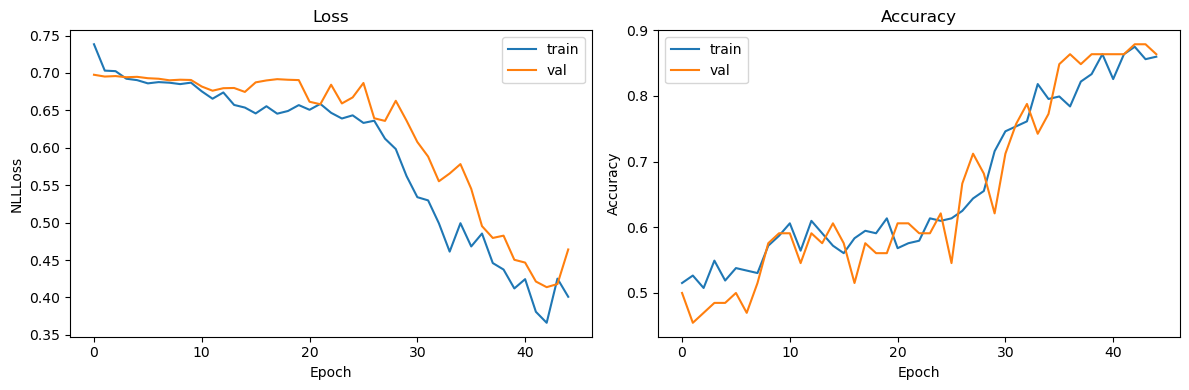

In [8]:
# Training loop with plots (per-graph, no DataLoader)
if (model is not None) and (len(train_dataset) > 0):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_dataset, optimizer, criterion)
        if len(val_dataset) > 0:
            vl_loss, vl_acc = evaluate(model, val_dataset, criterion)
        else:
            vl_loss, vl_acc = 0.0, 0.0

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(vl_loss)
        history["val_acc"].append(vl_acc)

        print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

    # Plot loss and accuracy
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history["train_loss"], label="train")
    axs[0].plot(history["val_loss"], label="val")
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("NLLLoss")
    axs[0].legend()

    axs[1].plot(history["train_acc"], label="train")
    axs[1].plot(history["val_acc"], label="val")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("No dataset or model available. Build/load dataset and initialize model first.")

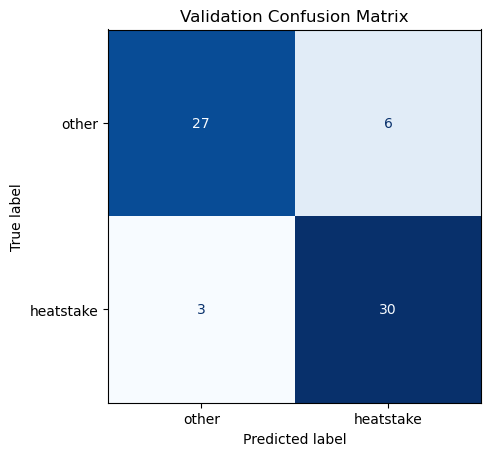


Validation Classification Report:
              precision    recall  f1-score   support

       other       0.90      0.82      0.86        33
   heatstake       0.83      0.91      0.87        33

    accuracy                           0.86        66
   macro avg       0.87      0.86      0.86        66
weighted avg       0.87      0.86      0.86        66



In [9]:
# Confusion Matrix on validation set (or train set if no val)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

def _collect_preds_targets(model, dataset):
    model.eval()
    ys, y_preds = [], []
    with torch.no_grad():
        for data in dataset:
            data = data.to(DEVICE)
            out = model(adj=data.edge_index, features=data.x)
            pred = out.argmax(dim=1).item()
            y_preds.append(pred)
            ys.append(int(data.y.item()))
    return np.array(ys), np.array(y_preds)

if (model is not None) and (len(train_dataset) > 0 or len(val_dataset) > 0):
    eval_set_name = "Validation" if len(val_dataset) > 0 else "Train"
    eval_set = val_dataset if len(val_dataset) > 0 else train_dataset

    y_true, y_pred = _collect_preds_targets(model, eval_set)

    labels = [0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "heatstake"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{eval_set_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    try:
        print(f"\n{eval_set_name} Classification Report:")
        print(classification_report(y_true, y_pred, target_names=["other", "heatstake"]))
    except Exception as e:
        print("Could not generate classification report:", e)

In [10]:
torch.save(model.state_dict(), BASE_DIR / "GCN" / "heatstake_classifier3.pth")